In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [7]:
# ==============================================================================
# 1. Data Loading and Preprocessing for Nifty 50
# ==============================================================================

# Download the list of Nifty 50 companies from Wikipedia.
try:
    nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[1]
    print("Successfully loaded Nifty 50 constituents table.")
except Exception as e:
    print(f"Error loading Nifty 50 data from Wikipedia: {e}")
    nifty50 = pd.DataFrame() # Avoid further errors

# Append '.NS' to each symbol for compatibility with Yahoo Finance for Indian stocks.
if 'Symbol' in nifty50.columns:
    nifty50['Symbol'] = nifty50['Symbol'].astype(str) + '.NS'
    symbols_list = nifty50['Symbol'].unique().tolist()
    # Remove known problematic tickers that were not listed for the full period
    problem_tickers = ['ETERNAL.NS', 'JIOFIN.NS', 'BEL.NS', 'TRENT.NS']
    symbols_list = [s for s in symbols_list if s not in problem_tickers]
else:
    print("Could not find 'Symbol' column. Using a default list.")
    symbols_list = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS']

# Download historical data for the Nifty 50 stocks.
print(f"\nDownloading data for {len(symbols_list)} stocks...")
data = yf.download(symbols_list, start='2020-01-01', end='2025-01-01', auto_adjust=True)

# Restructure the data by selecting the 'Close' column
adj_close_data = data['Close']

# Drop columns with all NaN values (for any stocks that failed to download)
adj_close_data.dropna(axis=1, how='all', inplace=True)
print(f"\nSuccessfully downloaded data for {adj_close_data.shape[1]} stocks.")

Successfully loaded Nifty 50 constituents table.



[*********************100%***********************]  46 of 46 completed


Successfully downloaded data for 46 stocks.



/tmp/ipython-input-7-512456746.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_data.dropna(axis=1, how='all', inplace=True)


In [11]:
# ==============================================================================
# 2. Moving Average Crossover Strategy
# ==============================================================================

def moving_average_crossover_strategy(stock_data, short_window=50, long_window=200):
    """
    Implements the moving average crossover strategy.
    """
    signals = pd.DataFrame(index=stock_data.index)
    signals['signal'] = 0.0

    signals['short_mavg'] = stock_data.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = stock_data.rolling(window=long_window, min_periods=1, center=False).mean()

    signals.loc[signals.index[short_window:], 'signal'] = np.where(
        signals.loc[signals.index[short_window:], 'short_mavg'] > signals.loc[signals.index[short_window:], 'long_mavg'],
        1.0,
        0.0
    )

    signals['positions'] = signals['signal'].diff()
    return signals

In [12]:
# ==============================================================================
# 3. Mean Reversion Strategy (using RSI)
# ==============================================================================

def mean_reversion_strategy(stock_data, rsi_period=14, rsi_overbought=70, rsi_oversold=30):
    """
    Implements a mean reversion strategy using the Relative Strength Index (RSI).
    """
    signals = pd.DataFrame(index=stock_data.index)
    signals['signal'] = 0.0

    delta = stock_data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    signals['rsi'] = 100 - (100 / (1 + rs))

    signals['signal'] = np.where(signals['rsi'] < rsi_oversold, 1.0, 0.0)
    signals['signal'] = np.where(signals['rsi'] > rsi_overbought, -1.0, signals['signal'])
    signals['positions'] = signals['signal'].diff()
    return signals

In [13]:
# ==============================================================================
# 4. Statistical Arbitrage (Pairs Trading) Strategy
# ==============================================================================

def find_cointegrated_pairs(data):
    """
    Finds cointegrated pairs of stocks.
    """
    n = data.shape[1]
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]].dropna()
            S2 = data[keys[j]].dropna()

            common_index = S1.index.intersection(S2.index)
            if len(common_index) < 20:
                continue
            S1 = S1.loc[common_index]
            S2 = S2.loc[common_index]

            result = coint(S1, S2)
            pvalue = result[1]
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pairs

def stat_arb_strategy(data, pairs):
    """
    Implements a statistical arbitrage strategy for given pairs.
    """
    if not pairs:
        print("No cointegrated pairs found.")
        return pd.DataFrame()

    pair = pairs[0]
    print(f"Using pair for StatArb: {pair}")
    S1 = data[pair[0]]
    S2 = data[pair[1]]

    spread = S1 - S2

    signals = pd.DataFrame(index=spread.index)
    signals['spread'] = spread
    signals['zscore'] = (spread - spread.mean()) / spread.std()

    signals['positions1'] = np.where(signals['zscore'] > 1, -1, 0)
    signals['positions1'] = np.where(signals['zscore'] < -1, 1, signals['positions1'])
    signals['positions2'] = -signals['positions1']

    returns1 = S1.pct_change()
    returns2 = S2.pct_change()

    portfolio_returns = (signals['positions1'].shift(1) * returns1) + (signals['positions2'].shift(1) * returns2)
    return portfolio_returns.to_frame('returns')

In [14]:
# ==============================================================================
# 5. Machine Learning-Based Strategy
# ==============================================================================

def ml_strategy(stock_data):
    """
    Implements a machine learning-based trading strategy.
    """
    signals = pd.DataFrame(index=stock_data.index)

    signals['returns'] = stock_data.pct_change()
    signals['price_change'] = stock_data.diff()
    signals['direction'] = np.where(signals['price_change'] > 0, 1, -1)

    for i in range(1, 6):
        signals[f'lag_{i}'] = signals['returns'].shift(i)

    signals = signals.dropna()

    X = signals[[f'lag_{i}' for i in range(1, 6)]]
    y = signals['direction']

    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    print(f'Machine Learning Strategy Accuracy: {accuracy_score(y_test, predictions):.2f}')

    ml_signals = pd.DataFrame(predictions, index=X_test.index, columns=['signal'])
    return ml_signals

In [15]:
# ==============================================================================
# 6. Backtesting and Performance Evaluation
# ==============================================================================

def backtest_strategy(stock_data, signals):
    """
    Backtests a trading strategy.
    """
    initial_capital = float(100000.0)
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    portfolio = pd.DataFrame(index=signals.index).fillna(0.0)

    aligned_data, aligned_signals = stock_data.align(signals, join='right', axis=0)

    if 'positions' in aligned_signals.columns:
        positions['stock'] = aligned_signals['positions'].apply(lambda x: 100 * x if x !=0 else 0)
    else:
        positions['stock'] = aligned_signals['signal'].apply(lambda x: 100 * x if x !=0 else 0)

    portfolio['holdings'] = (positions.multiply(aligned_data, axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (positions.diff().multiply(aligned_data, axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

def calculate_performance_metrics(portfolio_returns):
    """
    Calculates key performance metrics for a strategy.
    """
    if portfolio_returns.empty:
        return pd.Series({
            'Cumulative Return': 'N/A',
            'Annualized Volatility': 'N/A',
            'Sharpe Ratio': 'N/A'
        })

    # Total return over the period
    cumulative_return = (portfolio_returns.iloc[-1] / portfolio_returns.iloc[0]) - 1

    # Daily returns for volatility and Sharpe calculation
    daily_returns = portfolio_returns.pct_change().dropna()

    # Annualized Volatility (risk)
    annualized_volatility = daily_returns.std() * np.sqrt(252)

    # Annualized Sharpe Ratio (risk-adjusted return)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0

    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}"
    })


Available Nifty 50 Stocks for Analysis:
1. ADANIENT.NS
2. ADANIPORTS.NS
3. APOLLOHOSP.NS
4. ASIANPAINT.NS
5. AXISBANK.NS
6. BAJAJ-AUTO.NS
7. BAJAJFINSV.NS
8. BAJFINANCE.NS
9. BHARTIARTL.NS
10. CIPLA.NS
11. COALINDIA.NS
12. DRREDDY.NS
13. EICHERMOT.NS
14. GRASIM.NS
15. HCLTECH.NS
16. HDFCBANK.NS
17. HDFCLIFE.NS
18. HEROMOTOCO.NS
19. HINDALCO.NS
20. HINDUNILVR.NS
21. ICICIBANK.NS
22. INDUSINDBK.NS
23. INFY.NS
24. ITC.NS
25. JSWSTEEL.NS
26. KOTAKBANK.NS
27. LT.NS
28. M&M.NS
29. MARUTI.NS
30. NESTLEIND.NS
31. NTPC.NS
32. ONGC.NS
33. POWERGRID.NS
34. RELIANCE.NS
35. SBILIFE.NS
36. SBIN.NS
37. SHRIRAMFIN.NS
38. SUNPHARMA.NS
39. TATACONSUM.NS
40. TATAMOTORS.NS
41. TATASTEEL.NS
42. TCS.NS
43. TECHM.NS
44. TITAN.NS
45. ULTRACEMCO.NS
46. WIPRO.NS

Please select a stock by number (1-46): 33

Running strategies on: POWERGRID.NS

--- Running Moving Average Crossover ---

--- Running Mean Reversion ---

--- Running Statistical Arbitrage ---
Using pair for StatArb: ('ADANIPORTS.NS', 'CIPLA.NS')

---

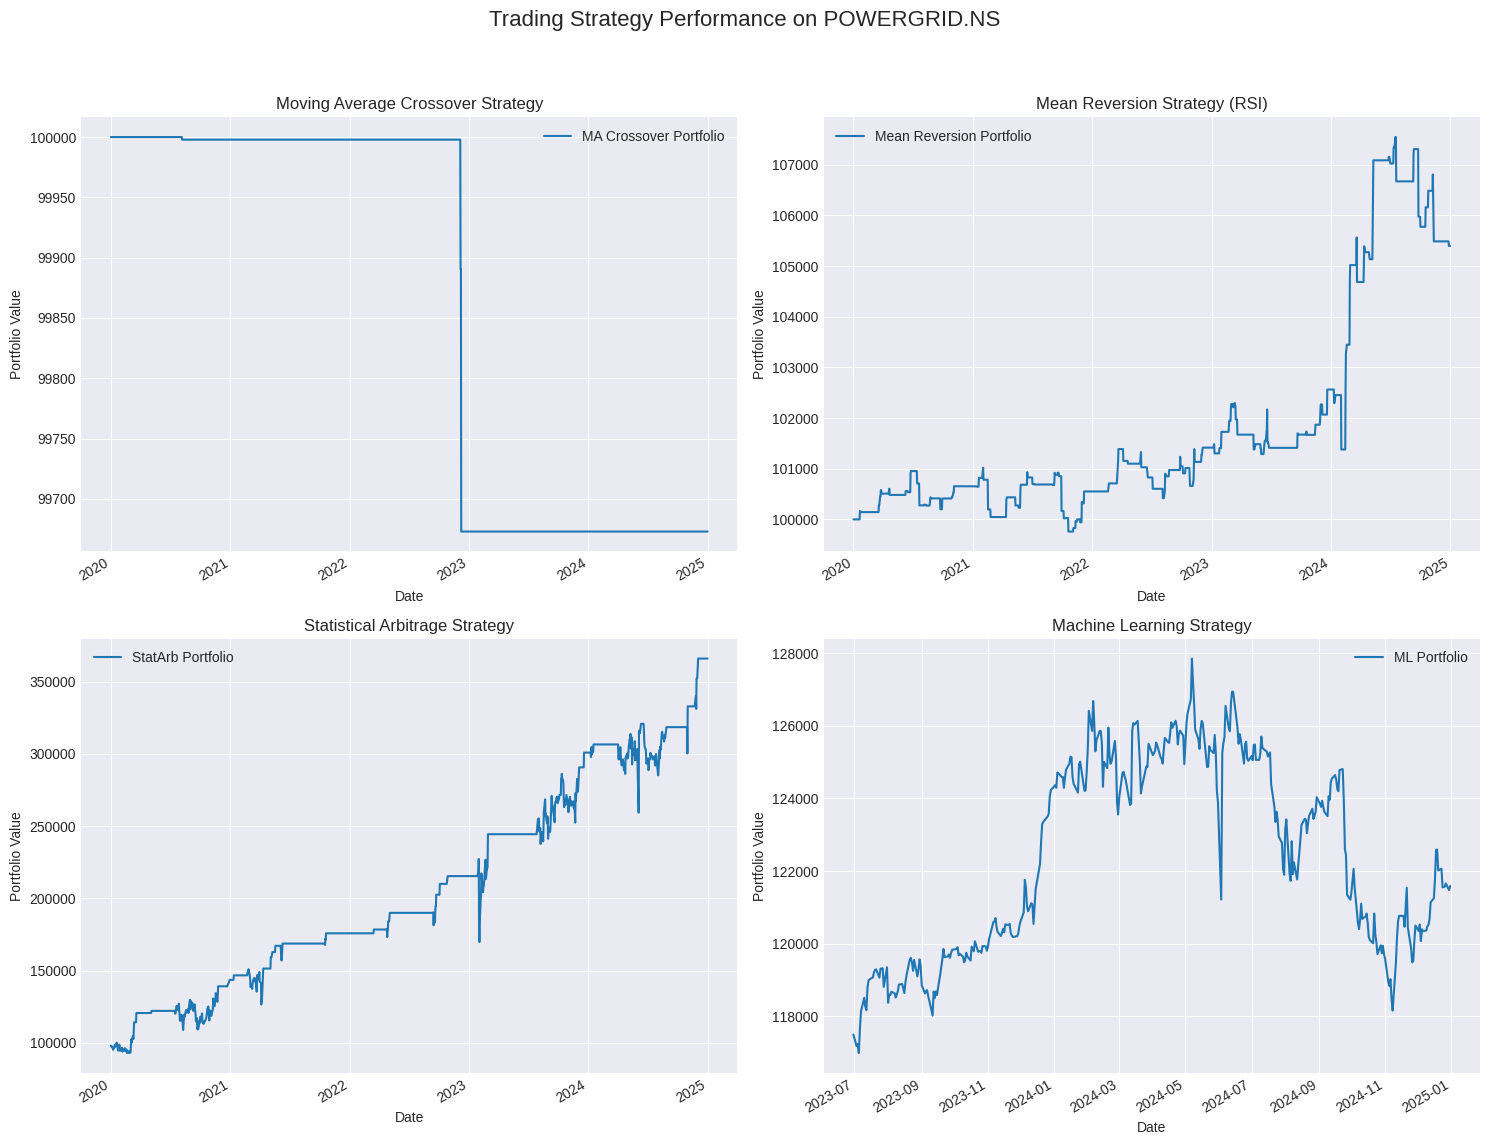

In [16]:
if __name__ == '__main__':
    if not adj_close_data.empty:
        # --- NEW: Interactive Stock Selection ---
        available_stocks = adj_close_data.columns.tolist()
        print("\nAvailable Nifty 50 Stocks for Analysis:")
        for i, stock in enumerate(available_stocks):
            print(f"{i+1}. {stock}")

        selected_stock_symbol = None
        while True:
            try:
                choice = int(input(f"\nPlease select a stock by number (1-{len(available_stocks)}): "))
                if 1 <= choice <= len(available_stocks):
                    selected_stock_symbol = available_stocks[choice-1]
                    break
                else:
                    print("Invalid number. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")

        print(f"\nRunning strategies on: {selected_stock_symbol}")
        sample_stock = adj_close_data[selected_stock_symbol].dropna()

        # --- Run Strategies ---
        print("\n--- Running Moving Average Crossover ---")
        ma_signals = moving_average_crossover_strategy(sample_stock)
        ma_portfolio = backtest_strategy(sample_stock, ma_signals)

        print("\n--- Running Mean Reversion ---")
        mr_signals = mean_reversion_strategy(sample_stock)
        mr_portfolio = backtest_strategy(sample_stock, mr_signals)

        print("\n--- Running Statistical Arbitrage ---")
        pairs = find_cointegrated_pairs(adj_close_data.iloc[:, :20])
        stat_arb_returns = stat_arb_strategy(adj_close_data, pairs)

        print("\n--- Running Machine Learning Strategy ---")
        ml_signals = ml_strategy(sample_stock)
        ml_portfolio = backtest_strategy(sample_stock, ml_signals)

        # --- NEW: Calculate and Display Performance Metrics ---
        metrics = {
            'MA Crossover': calculate_performance_metrics(ma_portfolio['total']),
            'Mean Reversion': calculate_performance_metrics(mr_portfolio['total']),
            'Machine Learning': calculate_performance_metrics(ml_portfolio['total']),
        }
        if not stat_arb_returns.empty:
            stat_arb_total = (1 + stat_arb_returns['returns']).cumprod() * 100000
            metrics['Stat. Arbitrage'] = calculate_performance_metrics(stat_arb_total)

        performance_df = pd.DataFrame(metrics)
        print("\n" + "="*50)
        print(f"Strategy Performance Comparison for: {selected_stock_symbol}")
        print("="*50)
        print(performance_df)
        print("="*50 + "\n")


        # --- Plotting Results ---
        print("Plotting results...")
        plt.style.use('seaborn-v0_8-darkgrid')
        plt.figure(figsize=(15, 12))
        plt.suptitle(f'Trading Strategy Performance on {selected_stock_symbol}', fontsize=16)

        ax1 = plt.subplot(2, 2, 1)
        ma_portfolio['total'].plot(ax=ax1, label='MA Crossover Portfolio')
        plt.title('Moving Average Crossover Strategy')
        plt.ylabel('Portfolio Value')
        plt.legend()

        ax2 = plt.subplot(2, 2, 2)
        mr_portfolio['total'].plot(ax=ax2, label='Mean Reversion Portfolio')
        plt.title('Mean Reversion Strategy (RSI)')
        plt.ylabel('Portfolio Value')
        plt.legend()

        ax3 = plt.subplot(2, 2, 3)
        if not stat_arb_returns.empty:
          stat_arb_total.plot(ax=ax3, label='StatArb Portfolio')
        plt.title('Statistical Arbitrage Strategy')
        plt.ylabel('Portfolio Value')
        plt.legend()

        ax4 = plt.subplot(2, 2, 4)
        ml_portfolio['total'].plot(ax=ax4, label='ML Portfolio')
        plt.title('Machine Learning Strategy')
        plt.ylabel('Portfolio Value')
        plt.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("\nCould not run strategies because no stock data was loaded.")